## 0. References:
#### https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

## 1. Import data and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [2]:
total = pd.read_csv(os.getcwd()+'\\total.csv')
TTRAFFICREMOVE_RF = pd.read_csv(os.getcwd()+'\\TTRAFFICREMOVE_RF.csv')
pd.set_option('display.max_rows', 110)
total.head()

clearspeed0  nextrainspeed0  prevrainspeed0  prevspeed0  currspeed0  \
0          3.0             6.0             5.0         5.0         3.0   
1          3.0             6.0             5.0         5.0         3.0   
2          3.0             6.0             5.0         5.0         3.0   
3          3.0            52.0            43.0        43.0         3.0   
4          3.0            53.0            49.5        49.5         3.0   

   nextspeed0  prevtravel_time0  currtravel_time0  nexttravel_time0  \
0         6.0           182.640           304.400           152.200   
1         6.0           182.640           304.400           152.200   
2         6.0           182.640           304.400           152.200   
3        52.0            70.515           947.275            54.650   
4        53.0            58.545           947.275            54.265   

   prevconf_score0   ...     phl1purple  phl2orange phl2blue phl2green  \
0               30   ...              0           0        0         0   
1               30   ...              0           0        0         0   
2               30   ...              0           0        0         0   
3               30   ...              0           0        0         0   
4               30   ...              0           0        0         0   

  pit1orange pit1red pit1blue pit1purple pit2red pit2blue  
0          0       0        0          0       0        0  
1          0       0        0          0       0        0  
2          0       0        0          0       0        0  
3          0       0        0          0       0        0  
4          0       0        0          0       0        0  

[5 rows x 121 columns]

In [3]:
TTRAFFICREMOVE_RF.columns.values

array(['month', 'hour', 'direction', 'precipitation', 'visibility',
       'location', 'speedlimit', 'ampm', 'speed'], dtype=object)

In [4]:
# Combine Corridor and Direction:
corridor_df = total[['avppurple', 'avpblack', 'phl1orange',
       'phl1red', 'phl1blue', 'phl1purple', 'phl2orange', 'phl2blue',
       'phl2green', 'pit1orange', 'pit1red', 'pit1blue', 'pit1purple',
       'pit2red', 'pit2blue']]
corridorindex = np.array([[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]])
corridorindex = corridorindex.transpose(1,0)
corridor = corridor_df.values
corridor = np.dot(corridor, corridorindex)
d = {1:'avppurple', 2:'avpblack', 3:'phl1orange',
       4:'phl1red', 5:'phl1blue', 6:'phl1purple', 7:'phl2orange', 8:'phl2blue',
       9:'phl2green', 10:'pit1orange', 11:'pit1red', 12:'pit1blue', 13:'pit1purple',
       14:'pit2red', 15:'pit2blue'}
temp = np.asarray(corridor.transpose(1,0)[0])
corridorname = np.empty(len(corridor), dtype=object)
for i in range(1,16):
    corridorname[np.where(temp==i)] = d[i]
del d, temp, corridor, corridorindex
corridorname_df = pd.Series(corridorname)
TTRAFFICREMOVE_RF['corridorname'] = corridorname_df
TTRAFFICREMOVE_RF.head()

month  hour    direction  precipitation  visibility location  speedlimit  \
0      6     7  SOUTHorWEST           0.16         4.0      PIT          55   
1      6     7  SOUTHorWEST           0.16         4.0      PIT          55   
2      6     7  SOUTHorWEST           0.16         4.0      PIT          55   
3      8     8  NORTHorEAST           0.51        10.0      PHL          55   
4      8     8  NORTHorEAST           0.51        10.0      PHL          55   

  ampm  speed corridorname  
0   AM    3.0   phl1orange  
1   AM    3.0   phl1orange  
2   AM    3.0   phl1orange  
3   AM    3.0     phl1blue  
4   AM    3.0     phl1blue

In [5]:
# one-hot encoding using get_dummies
month = pd.get_dummies(TTRAFFICREMOVE_RF.month)
hour = pd.get_dummies(TTRAFFICREMOVE_RF.hour)
speedlimit = pd.get_dummies(TTRAFFICREMOVE_RF.speedlimit)
ampm = pd.get_dummies(TTRAFFICREMOVE_RF.ampm)
corridorname = pd.get_dummies(TTRAFFICREMOVE_RF['corridorname'])

TTRAFFICREMOVE_RF = TTRAFFICREMOVE_RF.drop(['month','hour','direction','location','speedlimit','ampm','corridorname'], axis=1)
TTRAFFICREMOVE_RF = pd.concat([month, hour, speedlimit, ampm, corridorname, TTRAFFICREMOVE_RF], axis=1)
TTRAFFICREMOVE_RF.head()

5  6  7  8  9  10  7  8  16  17  ...    phl2orange  pit1blue  pit1orange  \
0  0  1  0  0  0   0  1  0   0   0  ...             0         0           0   
1  0  1  0  0  0   0  1  0   0   0  ...             0         0           0   
2  0  1  0  0  0   0  1  0   0   0  ...             0         0           0   
3  0  0  0  1  0   0  0  1   0   0  ...             0         0           0   
4  0  0  0  1  0   0  0  1   0   0  ...             0         0           0   

   pit1purple  pit1red  pit2blue  pit2red  precipitation  visibility  speed  
0           0        0         0        0           0.16         4.0    3.0  
1           0        0         0        0           0.16         4.0    3.0  
2           0        0         0        0           0.16         4.0    3.0  
3           0        0         0        0           0.51        10.0    3.0  
4           0        0         0        0           0.51        10.0    3.0  

[5 rows x 35 columns]

In [6]:
TTRAFFICREMOVE_RF.columns.values

array([5, 6, 7, 8, 9, 10, 7, 8, 16, 17, 40, 45, 50, 55, 65, 'AM', 'PM',
       'avpblack', 'avppurple', 'phl1blue', 'phl1orange', 'phl1purple',
       'phl1red', 'phl2blue', 'phl2green', 'phl2orange', 'pit1blue',
       'pit1orange', 'pit1purple', 'pit1red', 'pit2blue', 'pit2red',
       'precipitation', 'visibility', 'speed'], dtype=object)

In [7]:
feature_names = ['May','Jun','Jul','Aug','Sep','Oct','7AM','8AM','16PM',
                 '17PM','40mph','45mph','50mph','55mph','65mph','AM','PM',
                 'avpblack', 'avppurple', 'phl1blue','phl1orange','phl1purple',
                 'phl1red', 'phl2blue', 'phl2green', 'phl2orange', 'pit1blue',
                 'pit1orange', 'pit1purple', 'pit1red', 'pit2blue', 'pit2red',
                 'precipitation','visibility','speed']
TTRAFFICREMOVE_RF.columns = feature_names
print(TTRAFFICREMOVE_RF.columns.values)
TTRAFFICREMOVE_RF.shape

['May' 'Jun' 'Jul' 'Aug' 'Sep' 'Oct' '7AM' '8AM' '16PM' '17PM' '40mph'
 '45mph' '50mph' '55mph' '65mph' 'AM' 'PM' 'avpblack' 'avppurple'
 'phl1blue' 'phl1orange' 'phl1purple' 'phl1red' 'phl2blue' 'phl2green'
 'phl2orange' 'pit1blue' 'pit1orange' 'pit1purple' 'pit1red' 'pit2blue'
 'pit2red' 'precipitation' 'visibility' 'speed']


(18303, 35)

In [9]:
TTRAFFICREMOVE_RF.to_csv('TTRAFFICREMOVE_RF_R.csv')

In [10]:
# labels are target variable (speed)
speed = np.array(TTRAFFICREMOVE_RF['speed'])
TTRAFFICREMOVE_RF = TTRAFFICREMOVE_RF.drop('speed', axis=1)
feature_list = list(TTRAFFICREMOVE_RF.columns)
TTRAFFICREMOVE_RF = np.array(TTRAFFICREMOVE_RF)

## 2. Data set partition

In [11]:
# Training and test set split
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(TTRAFFICREMOVE_RF, speed, test_size=0.25, random_state=42)
print('training feature shape: ', train_features.shape)
print('testing feature shape: ', test_features.shape)
print('training labels shape: ', train_labels.shape)
print('testing labels shape: ', test_labels.shape)

training feature shape:  (13727, 34)
testing feature shape:  (4576, 34)
training labels shape:  (13727,)
testing labels shape:  (4576,)


## 3. Train and interpret Random Forest

In [26]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [27]:
# make prediction using testing set
predictions = rf.predict(test_features)

# calculate the MAE
mae = abs(predictions - test_labels)

# calculate the RMSE
from sklearn.metrics import mean_squared_error
import sklearn.metrics
from math import sqrt
rmse = sqrt(mean_squared_error(test_labels, predictions))
mse = rmse**2

Rsquare = sklearn.metrics.r2_score(test_labels, predictions, multioutput='uniform_average')
print('Mean Absolute Error:', round(np.mean(mae), 2), 'degrees.')
print('Rooted Mean Square Error: ', rmse)
print('Mean Square Error: ', mse)
print('R square: ', Rsquare)

Mean Absolute Error: 6.99 degrees.
Rooted Mean Square Error:  9.403010115593917
Mean Square Error:  88.41659923396152
R square:  0.677444680621


In [28]:
# calculate mean absolute percentage error (MAPE)
mape = 100 * (mae / test_labels)

# calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('accuracy: ', round(accuracy, 2), '%.')

accuracy:  75.9 %.


# RMSE and MSE might be wrong

#### New model's improvement:
* 1. Prediction Accuracy: 68.32% --> 75.89%
* 2. R square: 0.5866 --> 0.6773
* 3. RMSE: 3.263 --> 9.405
* 4. MSE: 10.645 --> 88.449

In [15]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydot
from IPython.display import Image
import pydotplus

# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, 
                rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.940391 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.940391 to fit



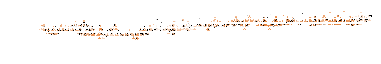

In [16]:
import matplotlib.image as mpimg
from PIL import *
img = mpimg.imread('tree.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

#### It's hard to show each tree clearly. To make it easier to see, the following cell will show a smaller tree whose depth is limited.

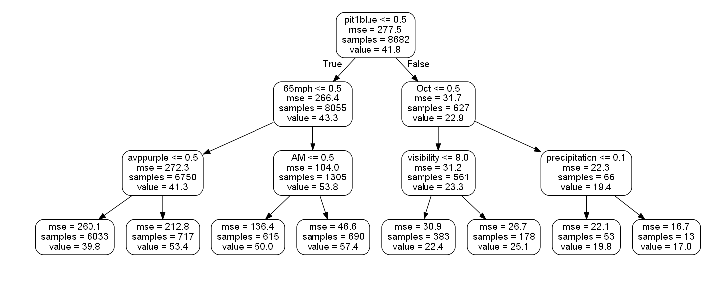

In [17]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');
plt.figure(figsize=(12,8))
img = mpimg.imread('small_tree.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

#### The first level is root node. Each line of root node rectange means:
* 1. Variable and value to split Node on
* 2. Mean Square Error of Node
* 3. Number of data points in this node
* 4. Prediction (in degrees) for all data points in node

#### The final level is leaf node level

## 4. Visualize Feature Importance and Conclusion

In order to quantify the contribution of each feature to the whole random forest model, we should look at the relative importance of each feature. In this study, I'm using sklearn.RandomForestRegressor. By doing that we can find how much the prediction is improved after adding each feature. 

In [18]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: 65mph                Importance: 0.12
Variable: precipitation        Importance: 0.1
Variable: visibility           Importance: 0.09
Variable: avppurple            Importance: 0.07
Variable: pit1blue             Importance: 0.07
Variable: 40mph                Importance: 0.06
Variable: avpblack             Importance: 0.05
Variable: phl1orange           Importance: 0.05
Variable: pit2blue             Importance: 0.04
Variable: 55mph                Importance: 0.03
Variable: AM                   Importance: 0.03
Variable: Jun                  Importance: 0.02
Variable: Jul                  Importance: 0.02
Variable: Sep                  Importance: 0.02
Variable: 8AM                  Importance: 0.02
Variable: 17PM                 Importance: 0.02
Variable: PM                   Importance: 0.02
Variable: phl1purple           Importance: 0.02
Variable: phl2blue             Importance: 0.02
Variable: pit1orange           Importance: 0.02
Variable: pit2red              Importance

The result above can tell us that, in congested condition:
1. Philadelphia has the highest impact on travel speed.If a vehicle is travelling in Philadelphia area, its speed is more likely to be lower. But the other two regions, Scranton and Pittsburgh, don't have very obvious impact on speed.
2. Not surprisingly, the second most importance feature is precipitation.
3. The other two important features can be visibility and direction. This means that vehicles' travel speeds in different direction can also be different. Visibility has impact on speed.
4. For speed limit, 40 mph can be an important factor to affect travel speed. But, when speed limit is higher or equal to 45 mph, this impact can be small.
5. Intuitively, month-of-year, morning/evening peak hour don't affect travel speed significantly.

Text(0.5, 1.0, 'Feature Importance Plot')

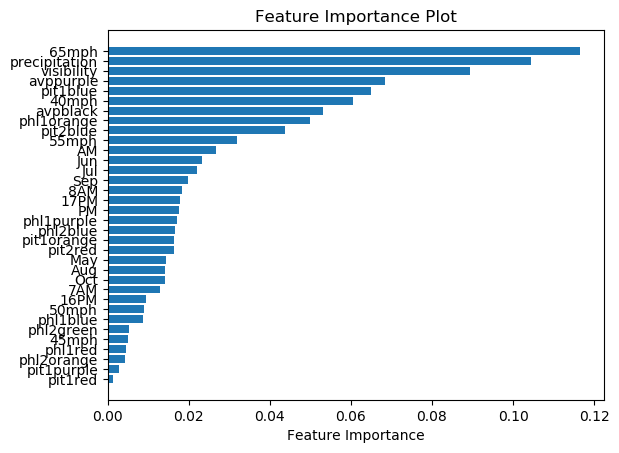

In [19]:
feature = []
for i in feature_importances:
    feature.append(str(i[0]))
    
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(np.arange(len(feature_importances)), sorted(importances, reverse=True), align='center') # feature_importances
ax.set_yticks(np.arange(len(feature_importances)))
ax.set_yticklabels(feature)
ax.invert_yaxis()
ax.set_xlabel('Feature Importance')
ax.set_title('Feature Importance Plot')

# 4. Gradient Boosting
#### The Partial Dependence Plot (PDP) is only doable in Gradient Boosting in Python. So, I also performed Gradient Boosting algorithm for this dataset. Finally, the PDP is displayed.
* PDP is a very general method, but, currently, Python does not have this package for Random Forest.
* It seems that PDP is doable for Random Forest in R. Due to time limitation, I didn't update my Random Forest code in R.
* Gradient Boosting can have a better performance than Random Forest, but this requires much time on hyper-parameter tuning.
* References: https://christophm.github.io/interpretable-ml-book/pdp.html

In [20]:
# Gradient Boosting
import glob

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter

In [21]:
import time
from sklearn.metrics import r2_score
start_time = time.time()
params = {'n_estimators': 1500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(train_features, train_labels)

r_square_gbm = clf.score(train_features, train_labels)
print('R-square: %.4f' % r_square_gbm)

y_pred = clf.predict(test_features)

mse = mean_squared_error(test_labels, clf.predict(test_features))
print('MSE: %.4f' % mse)
print('RMSE: %.4f' % sqrt(mse))

r_square_gbm_tested = r2_score(test_labels, y_pred)
print('Test R-square: %.4f' % r_square_gbm_tested)

# calculate mean absolute percentage error (MAPE)
mae_gbm = abs(y_pred - test_labels)
mape_gbm = 100 * (mae_gbm / test_labels)
# calculate and display accuracy
accuracy_gbm = 100 - np.mean(mape_gbm)
print('accuracy: ', round(accuracy_gbm, 2), '%.')


print("--- %s seconds ---" % (time.time() - start_time))

R-square: 0.6241
MSE: 103.5188
RMSE: 10.1744
Test R-square: 0.6224
accuracy:  71.64 %.
--- 91.6731026172638 seconds ---


#### MSE is still higher than Random Forest
# 5. Learning Curve of Gradient Boosting

Text(0, 0.5, 'Deviance')

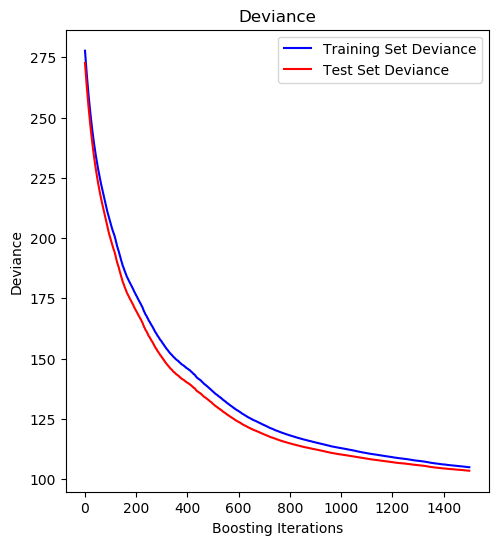

In [22]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(test_features)):
    test_score[i] = clf.loss_(test_labels, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

#### Gradient Boosting model's MSE decreased to 103 after 1500 iterations, which is still higher than Random Forest's
#### Further hyper-parameter tuning is still needed.
# 6. Visualize Feature Importance of Gradient Boosting

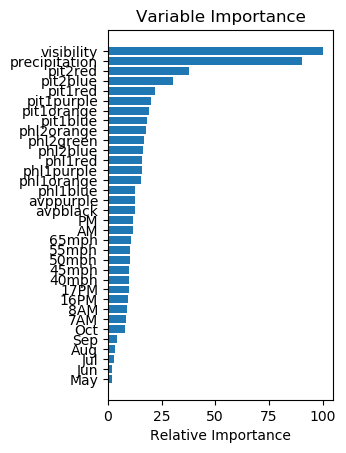

In [23]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# 7. Partial Dependence Plot of Gradient Boosting

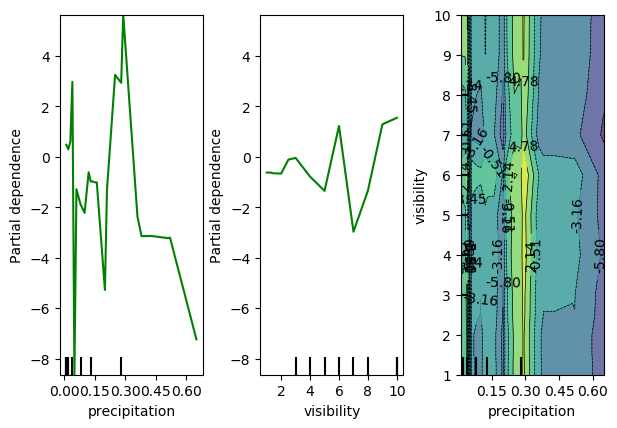

In [24]:
target_feature = [32, 33, (32,33)]
fig2, axs2 = plot_partial_dependence(clf, train_features, target_feature,
                                    feature_names=feature_names,
                                    n_jobs=3, grid_resolution=50)
fig.suptitle('Partial Dependence of Speed on Precipitation and Visibility')

plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle

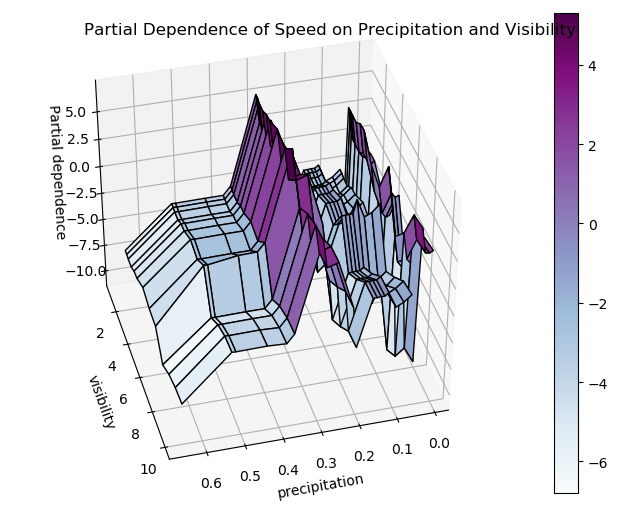

In [25]:
fig = plt.figure()

target_feature = (32,33)  # 32, 33 is precipitation and visibility 
pdp, axes = partial_dependence(clf, target_feature,
                               X=train_features, grid_resolution=50)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(feature_names[target_feature[0]])
ax.set_ylabel(feature_names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=40, azim=75)
plt.colorbar(surf)
plt.suptitle('Partial Dependence of Speed on Precipitation and Visibility')
plt.subplots_adjust(top=0.9)

plt.show()